In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Value iteration

In [2]:
class myGrid:
    def __init__(self, rows, cols, default_value=0):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols), dtype=float)
        self.grid.fill(default_value)
        self.obstacles = set()
    
    def set_value(self, row, col, value):
        if 0 <= row < self.rows and 0 <= col < self.cols:
            self.grid[row, col] = value
        else:
            raise ValueError("Position out of grid bounds")
    
    def get_value(self, row, col):
        if 0 <= row < self.rows and 0 <= col < self.cols:
            return self.grid[row, col]
        return None
        
    def add_obstacle(self, row, col):
        if 0 <= row < self.rows and 0 <= col < self.cols:
            self.obstacles.add((row, col))
            self.grid[row, col] = float('inf')  # Mark obstacle with infini
            
    def get_value(self, row, col):
        return self.grid[row, col]
        
grid = myGrid(4,5)
grid.add_obstacle(1,1)
grid.add_obstacle(2,2)

#Green cells
grid.set_value(0,2,1)
grid.set_value(1,2,1)
grid.set_value(2,3,1)
grid.set_value(3,0,1)

#Violet
grid.set_value(0,4,-1)
grid.set_value(3,4,-1)

#red
grid.set_value(2,1,10)
grid.set_value(3,3,10)
grid.set_value(1,4,10)


Converged after 1615 iterations
Time taken to complete value iteration: 0.15806961059570312


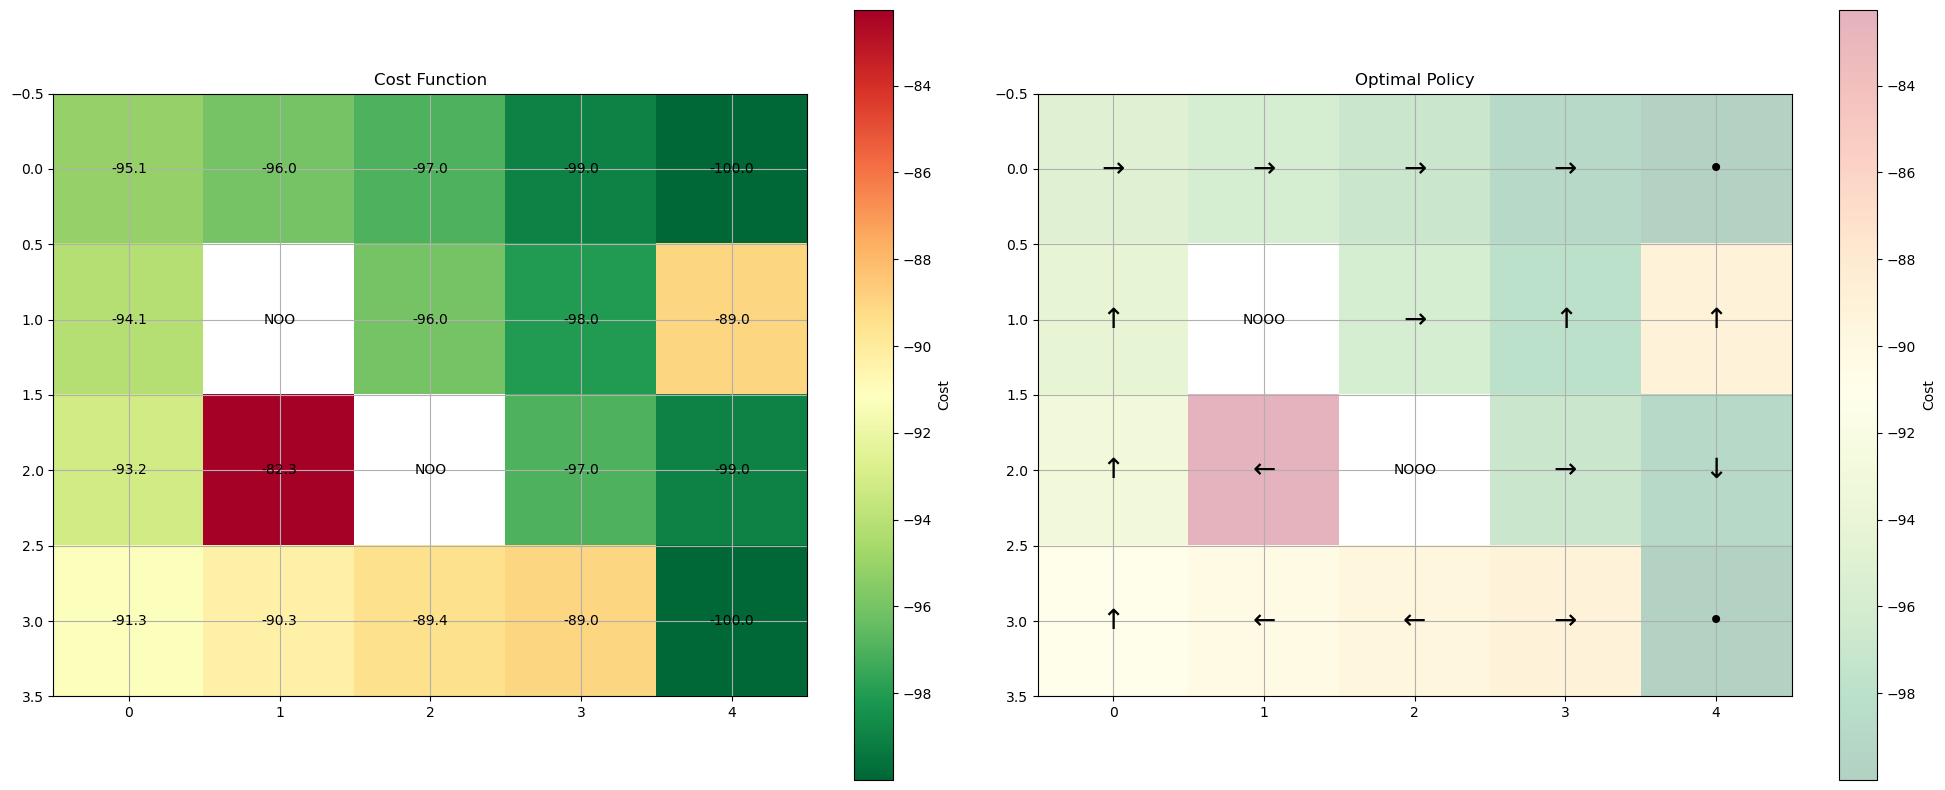

In [3]:
import numpy as np

def value_iteration(grid, gamma=0.99, epsilon=1e-6, max_iterations=2000):
    V = np.ones_like(grid.grid) * 1000
    actions = [(0, 0), (0, 1), (1, 0), (0, -1), (-1, 0)]  # Stay, Right, Down, Left, Up
    policy = np.zeros_like(grid.grid, dtype=int)
    
    def is_valid(state):
        row, col = state
        return (0 <= row < grid.rows and 
                0 <= col < grid.cols and 
                (row, col) not in grid.obstacles)
    
    def get_cost(state):
        row, col = state
        value = grid.get_value(row, col)
        if value == -1:  # violet cell
            return -1
        elif value == 0:  # white cell
            return 0
        elif value == 1:  # green cell
            return 1
        elif value == 10:  # red cell
            return 10
        return float('inf')  # obstacle
    
    for iteration in range(max_iterations):
        V_prev = V.copy()
        delta = 0
        
        for row in range(grid.rows):
            for col in range(grid.cols):
                if (row, col) in grid.obstacles:
                    V[row, col] = float('inf')
                    continue
                
                current_cost = get_cost((row, col))
                values = []
                for action_idx, action in enumerate(actions):
                    next_row = row + action[0]
                    next_col = col + action[1]
                    
                    if is_valid((next_row, next_col)):
                        values.append(current_cost + gamma * V_prev[next_row, next_col])
                    else:
                        values.append(1000)
                
                V[row, col] = min(values)
                policy[row, col] = np.argmin(values)
                delta = max(delta, abs(V[row, col] - V_prev[row, col]))
        
        if delta < epsilon:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    return V, policy

def visualize_policy_and_costs(grid, costs, policy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Cost visualization
    im1 = ax1.imshow(costs, cmap='RdYlGn_r')
    for i in range(grid.rows):
        for j in range(grid.cols):
            if (i, j) in grid.obstacles:
                ax1.text(j, i, 'NOO', ha='center', va='center')
            else:
                ax1.text(j, i, f'{costs[i,j]:.1f}', ha='center', va='center')
    plt.colorbar(im1, ax=ax1, label='Cost')
    ax1.grid(True)
    ax1.set_title('Cost Function')
    
    # Policy visualization
    im2 = ax2.imshow(costs, cmap='RdYlGn_r', alpha=0.3)
    arrows = ['•', '→', '↓', '←', '↑']  # Stay, Right, Down, Left, Up
    for i in range(grid.rows):
        for j in range(grid.cols):
            if (i, j) in grid.obstacles:
                ax2.text(j, i, 'NOOO', ha='center', va='center')
            else:
                action_idx = policy[i, j]
                ax2.text(j, i, arrows[action_idx], ha='center', va='center', fontsize=20)
    plt.colorbar(im2, ax=ax2, label='Cost')
    ax2.grid(True)
    ax2.set_title('Optimal Policy')
    
    plt.tight_layout()
    plt.show()

start = time.time()
optimal_costs, optimal_policy = value_iteration(grid)
Vi_time = time.time() - start
print(f'Time taken to complete value iteration: {Vi_time}')
visualize_policy_and_costs(grid, optimal_costs, optimal_policy)

# Policy Iteration

In [4]:
import numpy as np


class GridForPolicyIter:
    def __init__(self, rows, cols, default_value=0):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols), dtype=float)
        self.grid.fill(default_value)
        self.obstacles = set()
    
    def set_value(self, row, col, value):
        if 0 <= row < self.rows and 0 <= col < self.cols:
            self.grid[row, col] = value
    
    def get_value(self, row, col):
        return self.grid[row, col]

def get_cost(grid, state):
    row, col = state
    value = grid.get_value(row, col)
    if value == -1:  # violet cell
        return -1
    elif value == 0:  # white cell
        return 0
    elif value == 1:  # green cell
        return 1
    elif value == 10:  # red cell
        return 10
    elif value == 20: # Coded obstacle but could not invert so just gave a higher cost 
        return 20
    return float('inf')  # obstacle
    

def state_to_index(row, col, cols):
    return row * cols + col

def index_to_state(index, cols):
    return index // cols, index % cols

def policy_evaluation_matrix(grid, policy, gamma=0.99):
    """
  
    """
    N = grid.rows * grid.cols  # total states = 20 
    
    # Build cost vector g
    g = np.zeros(N)
    for i in range(N):
        row, col = index_to_state(i, grid.cols)
        g[i] = get_cost(grid, (row, col))
    
    # Build transition matrix A
    A = np.zeros((N, N))
    
    def is_valid(row, col):
        return 0 <= row < grid.rows and 0 <= col < grid.cols
    
    # Fill A matrix based on policy actions
    for i in range(N):
        row, col = index_to_state(i, grid.cols)
        action = policy[row, col]
        
        # Calculate next state based on action
        next_row, next_col = row, col
        if action == 0:    # stay
            pass
        elif action == 1:  # right
            next_col = col + 1
        elif action == 2:  # down
            next_row = row + 1
        elif action == 3:  # left
            next_col = col - 1
        elif action == 4:  # up
            next_row = row - 1
            
        if is_valid(next_row, next_col):
            next_state = state_to_index(next_row, next_col, grid.cols)
            A[i, next_state] = 1
        else:
            A[i, i] = 1  # stay in current state if invalid move
    
    #print("Cost vector g:", g)
 
    
    
    I = np.eye(N)
    J_policy = np.linalg.solve(I - gamma * A, g)
    #print("\nValue function:", V)
    
    return J_policy.reshape(grid.rows, grid.cols)

def policy_improvement(grid, J_policy, gamma=0.99):
    new_policy = np.zeros((grid.rows, grid.cols), dtype=int)
    actions = [0, 1, 2, 3, 4]  # stay, right, down, left, up
    
    def is_valid(row, col):
        return 0 <= row < grid.rows and 0 <= col < grid.cols
    
    def get_next_state_value(row, col, action):
        current_cost = get_cost(grid, (row, col))
        
        next_row, next_col = row, col
        if action == 1:    # right
            next_col = col + 1
        elif action == 2:  # down
            next_row = row + 1
        elif action == 3:  # left
            next_col = col - 1
        elif action == 4:  # up
            next_row = row - 1
            
        if is_valid(next_row, next_col):
            return current_cost + gamma * J_policy[next_row, next_col]
        else:
            return current_cost + gamma * J_policy[row, col]
    
    for row in range(grid.rows):
        for col in range(grid.cols):
            values = [get_next_state_value(row, col, action) for action in actions]
            new_policy[row, col] = actions[np.argmin(values)]
    
    return new_policy


grid = GridForPolicyIter(4, 5)

# Set cells for first row (row 0)
grid.set_value(0, 0, 0)   # white cell
grid.set_value(0, 1, 0)   # white cell
grid.set_value(0, 2, 1)   # green cell
grid.set_value(0, 3, 0)   # white cell
grid.set_value(0, 4, -1)  # violet cell (goal)

# Set cells for second row (row 1)
grid.set_value(1, 0, 0)   # white cell
grid.set_value(1, 1, 20)   # grey cell
grid.set_value(1, 2, 1)   # green cell
grid.set_value(1, 3, 0)   # white cell
grid.set_value(1, 4, 10)  # red cell 

# Set cells for third row (row 2)
grid.set_value(2, 0, 0)   # white cell
grid.set_value(2, 1, 10)   # red cell
grid.set_value(2, 2, 20)   # grey cell
grid.set_value(2, 3, 1)   # green cell
grid.set_value(2, 4, 0)  # white cell 

# Set cells for fourth row (row 3)
grid.set_value(3, 0, 1)   # green cell
grid.set_value(3, 1, 0)   # white cell
grid.set_value(3, 2, 0)   # white cell
grid.set_value(3, 3, 10)   # red cell
grid.set_value(3, 4, -1)  # violet cell (goal)

# Initial policy (all stay)
policy = np.zeros((4, 5), dtype=int)

print("Initial grid:")
print(grid.grid)
start = time.time()
# Run policy iteration
for i in range(10):
    print(f"\nIteration {i+1}")
    J_policy = policy_evaluation_matrix(grid, policy, gamma=0.99)
    new_policy = policy_improvement(grid, J_policy, gamma=0.99)
    
    if np.array_equal(new_policy, policy):
        print(f"Converged after {i+1} iterations")
        break
        
    policy = new_policy
    #print("Current policy:", policy)
Pi_time = time.time() - start
print(f'Time taken to compute:{Pi_time}')
# Visualize final policy with arrows
action_symbols = ['stay', '→', '↓', '←', '↑']
print("\nFinal Policy with arrows:")
for row in range(4):
    print([action_symbols[p] for p in policy[row]])


Initial grid:
[[ 0.  0.  1.  0. -1.]
 [ 0. 20.  1.  0. 10.]
 [ 0. 10. 20.  1.  0.]
 [ 1.  0.  0. 10. -1.]]

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9
Converged after 9 iterations
Time taken to compute:0.03636908531188965

Final Policy with arrows:
['→', '→', '→', '→', 'stay']
['↑', '↑', '→', '↑', '↑']
['↑', '←', '→', '→', '↓']
['↑', '←', '←', '→', 'stay']
